In [323]:
import numpy as np
import os
import sys
import tensorflow as tf
from glob import glob

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

from utils import label_map_util
from utils import visualization_utils as vis_util

In [324]:
CKPT = 'frozen_out/frozen_inference_graph.pb'

PATH_TO_LABELS = 'label/coco-car.pbtxt'

NUM_CLASSES = 90



image_path = 'data/KITTI/left/000016_10.png' 

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
#print(category_index)

detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(CKPT, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(1241, 376)
6


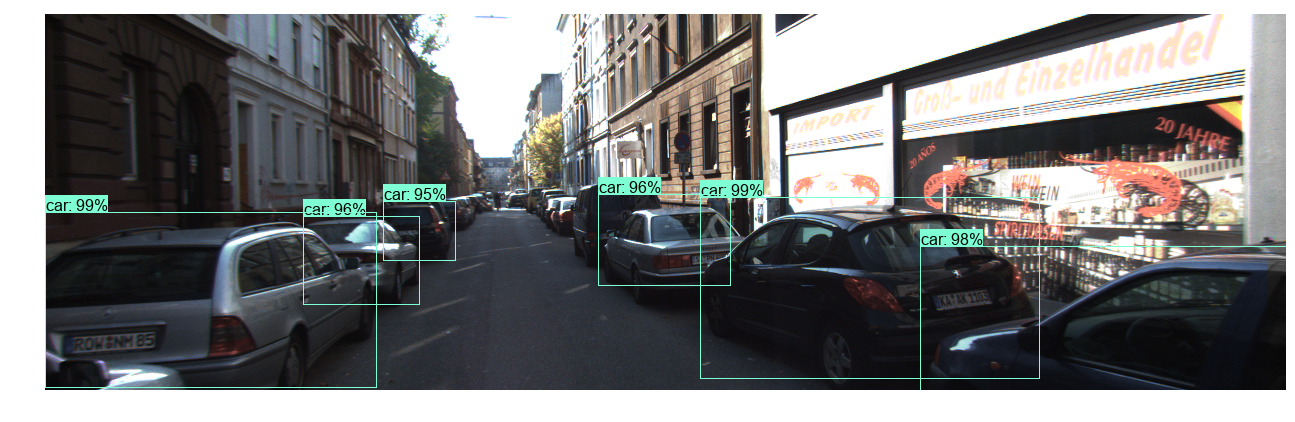

In [325]:
import time
import json
counter = 0
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
            
            #split= image_path.split('/')
            #filename = split[1]
            #print(filename)
        
        image = Image.open(image_path)
        print(image.size)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
        image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)

        time0 = time.time()

            # Actual detection.
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})

        time1 = time.time()
        detection_time = ((time1 - time0) * 1000)
            #with open('results-images/' + 'detection_time' '.txt','a') as text_file:
            #    text_file.write(filename + ': ' + str(detection_time) + ' ms' + '\n')
            #    text_file.close()
            #print("Time in milliseconds", (time1 - time0) * 1000) 

            # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=1, min_score_thresh=0.95)
            #plt.figure(figsize=IMAGE_SIZE)
        my_dpi = 96
            #plt.figure(figsize=(1241/my_dpi, 376/my_dpi), dpi=my_dpi, frameon=False)
            #plt.imshow(image_np)
            #plt.savefig('detection.png', dpi=my_dpi, frameon=False)
            #plt.show()
        fig = plt.figure(figsize=(image_np.shape[1]/my_dpi, image_np.shape[0]/my_dpi), dpi=my_dpi, frameon=False);
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.imshow(image_np)
        plt.savefig('detection.png', dpi=my_dpi, frameon=False)
            
        coordinates = vis_util.return_coordinates(
                    image,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=8,
                    min_score_thresh=0.95)
        print(len(coordinates))


In [326]:
points = []
for box in coordinates:
    del box[4:6]
    #print(box)
    xc = int((box[0] + box[1])/2)
    yc = int((box[2] + box[3])/2)
    points.append([xc,yc])
    
print(points)       

[[824, 273], [316, 246], [1058, 304], [374, 216], [165, 285], [619, 225]]


In [327]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from sklearn.preprocessing import normalize


left = cv2.imread('data/KITTI/left/000016_10.png',cv2.IMREAD_COLOR)
right = cv2.imread('data/KITTI/right/000016_10.png',cv2.IMREAD_COLOR)

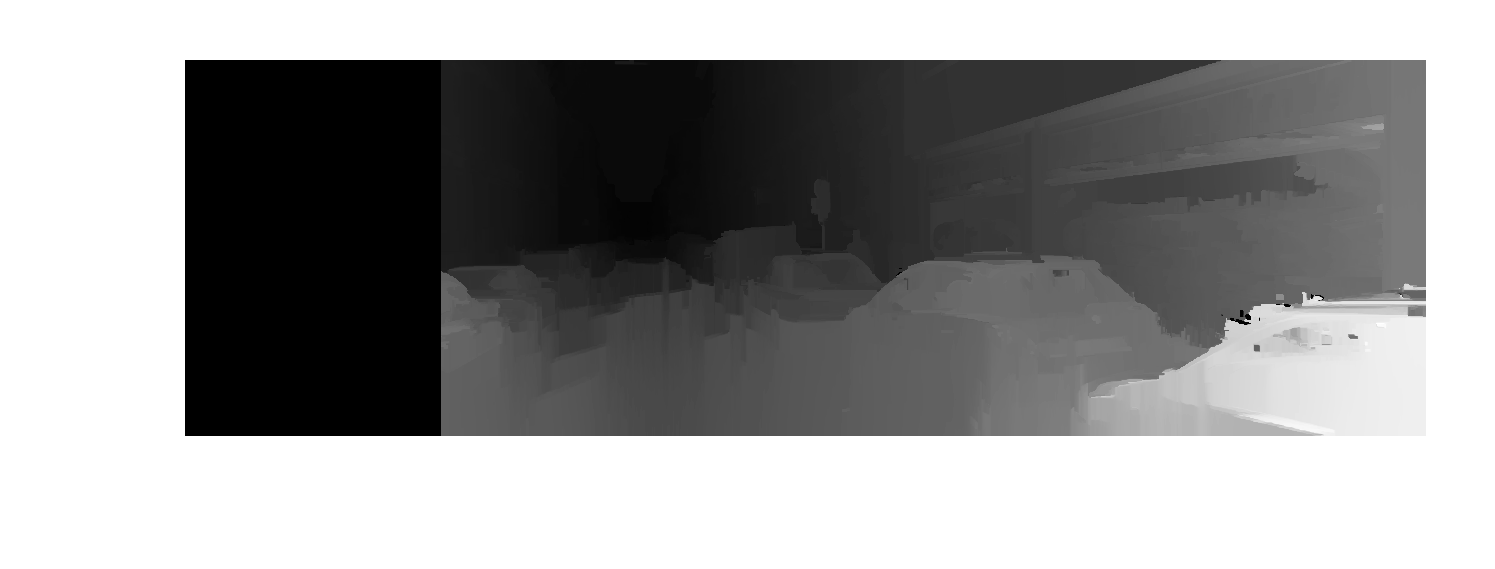

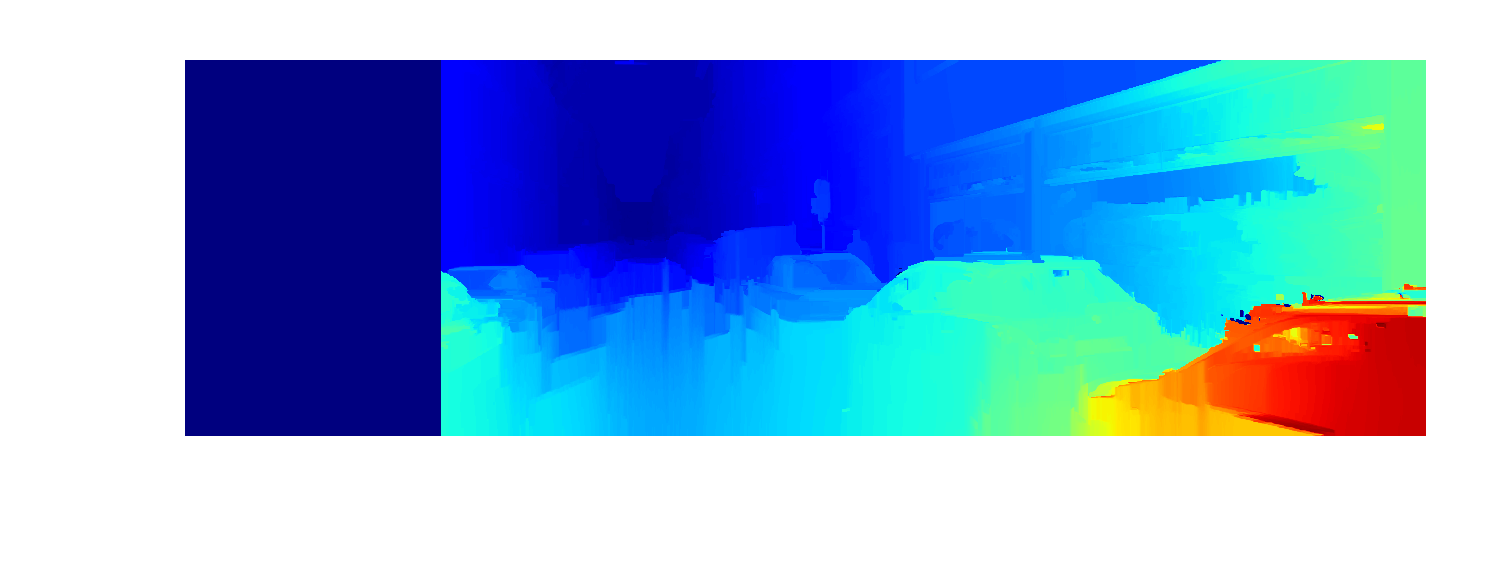

In [338]:
kernel_size = 3
smooth_left = cv2.GaussianBlur(left, (kernel_size,kernel_size), 1.5)
smooth_right = cv2.GaussianBlur(right, (kernel_size, kernel_size), 1.5)

window_size = 3    
left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=256,
    blockSize=4,
    P1=8*3*window_size**2,
    P2=32*3*window_size**2,
    #P1=600,
    #P2=2400,
    disp12MaxDiff=1,
    uniquenessRatio=16,
    speckleRange=2,
    #speckleWindowSize=150,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(80000)
wls_filter.setSigmaColor(1.2)

disparity_left = np.int16(left_matcher.compute(smooth_left, smooth_right))
disparity_right = np.int16(right_matcher.compute(smooth_right, smooth_left))

disparity = wls_filter.filter(disparity_left, smooth_left, None, disparity_right)
disparity = cv2.normalize(src=disparity, dst=disparity, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
disparity = np.uint8(disparity)

fig = plt.figure(figsize=(disparity.shape[1]/400, disparity.shape[0]/400), dpi=400, frameon=False);
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(disparity, cmap='gray')
fig.savefig('generated.png')
fig = plt.figure(figsize=(disparity.shape[1]/400, disparity.shape[0]/400), dpi=400, frameon=False);
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(disparity, cmap='jet')



In [340]:
b = 0.57

f = 718.856

generated = cv2.imread('generated.png',cv2.IMREAD_GRAYSCALE)
distance = (b*f)/(generated)
print(distance)
distance[375].shape
#disparity.shape
#left.shape

[[       inf        inf        inf ... 3.47244    3.47244    3.47244   ]
 [       inf        inf        inf ... 3.47244    3.47244    3.47244   ]
 [       inf        inf        inf ... 3.47244    3.47244    3.47244   ]
 ...
 [       inf        inf        inf ... 1.71442644 1.71442644 1.71442644]
 [       inf        inf        inf ... 1.71442644 1.71442644 1.71442644]
 [       inf        inf        inf ... 1.71442644 1.71442644 1.71442644]]


/home/nirmal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(1241,)

In [341]:
ref = Image.open('detection.png')
output = ImageDraw.Draw(ref)
fnt = ImageFont.truetype('fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', 16)

for point in points:
    print(point)
    xc = point[0]
    yc = point[1]
    #print(distance[yc][xc])
    output.text((xc,yc), str(round(distance[yc][xc],2)) + ' m', fill=(255,255,0), font=fnt)
    
    
ref.save('output.png')

[824, 273]
[316, 246]
[1058, 304]
[374, 216]
[165, 285]
[619, 225]


In [331]:
ref1 = Image.open('detection.png')
output1 = ImageDraw.Draw(ref1)
gt = cv2.imread('data/gt/1.png', cv2.IMREAD_GRAYSCALE)
for point in points:
    xc = point[0]
    yc = point[1]
    disparity = gt[yc][xc]
    distance = (b*f)/(disparity)
    print(distance)
    output1.text((xc,yc), str(round(distance,2)) + ' m', fill=(255,255,0), font=fnt)
    
ref1.save('output1.png')

6.025704705882353
9.993851707317072
3.4724399999999997
19.511805714285714
4.996925853658536
11.074268108108107


In [332]:
print(disparity)

37
